# Hypothesis

Given a users past shopping activity, we can accurately predict future purchases.

Initially, the model is based on:

* part of day (morning, eventing, afternoon, night)
* day (mon, tues...)
* amount spent
* market (Eua Claire, or Pittsville)
* Type of store (drug or supermarket)
* UPC (target, what product the user purchases)

Moving foward we can introduce demographic information into our model to improve accuracy.

In [200]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, BaggingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from sklearn import datasets
import pandas as pd
from sklearn import preprocessing, cross_validation
from pandas.tools.plotting import scatter_matrix
from sklearn import grid_search
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor, DecisionTreeClassifier, ExtraTreeClassifier
from itertools import combinations
from sklearn import decomposition
from sklearn.metrics import mean_squared_error
from collections import Counter

%pylab inline
pd.set_option('display.max_columns', 500)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [40]:
dr_sampling_rate=0.3
gr_sampling_rate=0.01

In [37]:
# local
saltsnck_dr_8=pd.read_fwf('saltsnck_drug_1479_1530').sample(frac=dr_sampling_rate)
saltsnck_dr_9=pd.read_fwf('saltsnck_drug_1531_1582').sample(frac=dr_sampling_rate)
saltsnck_dr_10=pd.read_fwf('saltsnck_drug_1583_1634').sample(frac=dr_sampling_rate)
saltsnck_dr_11=pd.read_fwf('saltsnck_drug_1635_1686').sample(frac=dr_sampling_rate)
saltsnck_dr_8_11=pd.concat([saltsnck_dr_8,saltsnck_dr_9,saltsnck_dr_10,saltsnck_dr_11]).reset_index(drop=True)
saltsnck_dr_8_11['OUTLET']='dr'

In [ ]:
saltsnck_gr_8=pd.read_fwf('saltsnck_groc_1479_1530').sample(frac=gr_sampling_rate)
saltsnck_gr_9=pd.read_fwf('saltsnck_groc_1531_1582').sample(frac=gr_sampling_rate)
saltsnck_gr_10=pd.read_fwf('saltsnck_groc_1583_1634').sample(frac=gr_sampling_rate)
saltsnck_gr_11=pd.read_fwf('saltsnck_groc_1635_1686').sample(frac=gr_sampling_rate)
saltsnck_gr_8_11=pd.concat([saltsnck_gr_8,saltsnck_gr_9,saltsnck_gr_10,saltsnck_gr_11]).reset_index(drop=True)
saltsnck_gr_8_11['OUTLET']='gr'

In [160]:
saltsnck_8_11=pd.concat([saltsnck_dr_8_11,saltsnck_gr_8_11])
saltsnck_8_11.head()

,IRI_KEY,WEEK,SY,GE,VEND,ITEM,UNITS,DOLLARS,F,D,PR,OUTLET
0,1131996,1489,0,1,28400,6450,13,12.87,NONE,1,1,dr
1,8042848,1496,0,1,37000,37705,2,2.98,NONE,2,1,dr
2,8041943,1527,0,1,28400,6461,6,17.94,B,2,1,dr
3,8029617,1498,0,2,74690,5539,2,4.98,NONE,0,0,dr
4,8004916,1502,0,1,28400,6497,5,4.95,NONE,0,0,dr


In [148]:
saltsnck_8_11.shape

(2042040, 12)

In [165]:
# explicit mapping of F feature to reflect the ad size/importance
saltsnck_8_11.ix[saltsnck_8_11.F=='NONE', 'F'] = 1
saltsnck_8_11.ix[saltsnck_8_11.F=='C', 'F'] = 2
saltsnck_8_11.ix[saltsnck_8_11.F=='B', 'F'] = 3
saltsnck_8_11.ix[saltsnck_8_11.F=='A', 'F'] = 4
saltsnck_8_11.ix[saltsnck_8_11.F=='A+', 'F'] = 5

In [44]:
prod = pd.read_excel('prod11_saltsnck.xlsx')[['SY','GE','VEND','ITEM','L2']]
prod.head(1)

,SY,GE,VEND,ITEM,L2
0,0,1,72556,50003,POTATO CHIPS


In [166]:
saltsnck_prod_8_11 = pd.merge(saltsnck_8_11, prod, on=['SY', 'GE','VEND','ITEM'])
saltsnck_prod_8_11.drop(['SY', 'GE','VEND','ITEM'],axis=1, inplace=True)
saltsnck_prod_8_11.head()

,IRI_KEY,WEEK,UNITS,DOLLARS,F,D,PR,OUTLET,L2
0,1131996,1489,13,12.87,1,1,1,dr,TORTILLA/TOSTADA CHIPS
1,8026464,1519,6,5.94,1,1,0,dr,TORTILLA/TOSTADA CHIPS
2,643033,1517,1,0.86,1,0,1,dr,TORTILLA/TOSTADA CHIPS
3,1108960,1483,7,6.93,1,0,0,dr,TORTILLA/TOSTADA CHIPS
4,8013058,1494,1,0.99,1,0,0,dr,TORTILLA/TOSTADA CHIPS


In [46]:
from datetime import date, datetime
week_season_translation=pd.read_excel('IRI week translation_2008_2017.xls')
week_season_translation = week_season_translation[\
    ['IRI Week', u'Calendar week starting on',u'Calendar week ending on']]

# if the date falls between March 21 and June 20, it is spring. Regardless of the year. 
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('fall', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]
    
def get_season(rawDate):
    aDate = rawDate
    #datetime.strptime(rawDate, '%Y-%m-%d')
    if isinstance(aDate, datetime):
        aDate = aDate.date()
    aDate = aDate.replace(year=Y)
    
    return next(season for season, (start, end) in seasons
                if start <= aDate <= end)

week_season_translation['season'] = week_season_translation['Calendar week starting on']
week_season_translation['season'] = week_season_translation['season'].apply(get_season)
print "week_season_translation.shape =", week_season_translation.shape
week_season_translation.rename(columns={'IRI Week':'WEEK'}, inplace=True)
week_season_translation['YEAR']=week_season_translation['Calendar week starting on'].apply(lambda x:x.year)
week_season_translation['MONTH']=week_season_translation['Calendar week starting on'].apply(lambda x:x.month)
week_season_translation.drop(['Calendar week starting on','Calendar week ending on'], axis=1, inplace=True)
week_season_translation.head()

week_season_translation.shape = (522, 4)


,WEEK,season,YEAR,MONTH
0,1479,winter,2007,12
1,1480,winter,2008,1
2,1481,winter,2008,1
3,1482,winter,2008,1
4,1483,winter,2008,1


In [167]:
saltsnck_final=pd.merge(saltsnck_prod_8_11,week_season_translation,on='WEEK')
saltsnck_final.head()

,IRI_KEY,WEEK,UNITS,DOLLARS,F,D,PR,OUTLET,L2,season,YEAR,MONTH
0,1131996,1489,13,12.87,1,1,1,dr,TORTILLA/TOSTADA CHIPS,winter,2008,3
1,8026909,1489,5,4.95,1,1,0,dr,TORTILLA/TOSTADA CHIPS,winter,2008,3
2,8004374,1489,7,6.93,1,0,0,dr,TORTILLA/TOSTADA CHIPS,winter,2008,3
3,681547,1489,4,3.96,1,0,0,dr,TORTILLA/TOSTADA CHIPS,winter,2008,3
4,932621,1489,2,1.98,1,2,0,dr,TORTILLA/TOSTADA CHIPS,winter,2008,3


# Data Cleaning

## Handling NaNs

In [48]:
# looking at the number of NaNs for each column #
saltsnck_final.isnull().sum()

IRI_KEY    0
WEEK       0
UNITS      0
DOLLARS    0
F          0
D          0
PR         0
OUTLET     0
L2         0
season     0
YEAR       0
MONTH      0
dtype: int64

In [49]:
def data_prep (data):
    # determining the non-numeric columns and transforming them into numeric using LabelEncoder() method
    real_or_str=data.applymap(np.isreal).all(0)
    non_num_feature=real_or_str[~real_or_str].keys()
    print "Non-numeric features are: ", non_num_feature
    le = preprocessing.LabelEncoder()
    for col in non_num_feature:
        #fill the NaN in non-numeric columns with the most used element#
        data.ix[:,col]=data.ix[:,col].fillna(data[col].describe().top)
        #transform the non-numeric columns to numeric values using 
        #LabelEncoder method from SKLearn#
        data.ix[:,col]=le.fit_transform(data.ix[:,col])
    #Filling in NaN values of numeric features with the mean value of the feature
    data=data.fillna(data.mean())
    return data

In [168]:
saltsnck_preped=data_prep(saltsnck_final)
saltsnck_preped.head()

Non-numeric features are:  Index([u'OUTLET', u'L2', u'season'], dtype='object')


,IRI_KEY,WEEK,UNITS,DOLLARS,F,D,PR,OUTLET,L2,season,YEAR,MONTH
0,1131996,1489,13,12.87,1,1,1,0,7,3,2008,3
1,8026909,1489,5,4.95,1,1,0,0,7,3,2008,3
2,8004374,1489,7,6.93,1,0,0,0,7,3,2008,3
3,681547,1489,4,3.96,1,0,0,0,7,3,2008,3
4,932621,1489,2,1.98,1,2,0,0,7,3,2008,3


In [206]:
saltsnck_preped_grp=saltsnck_preped.groupby(['IRI_KEY','YEAR']).agg({'L2': lambda x:Counter(x).most_common()[0][0],\
                                                    'F':'sum', 'D':'sum', 'PR':'sum', 'UNITS':'sum','DOLLARS':'sum'}).reset_index(drop=True)
saltsnck_preped_grp.head(5)

,PR,D,F,DOLLARS,L2,UNITS
0,272,87,1422,5657.49,4,4017
1,297,249,1646,7526.94,4,4781
2,378,110,1818,7770.60,4,5319
3,402,198,1894,8529.51,4,5058
4,6,0,17,99.82,4,49


,PR,D,F,DOLLARS,L2,UNITS
count,2436.000000,2436.000000,2436.000000,2436.000000,2436.000000,2436.000000
mean,232.357143,290.993842,1051.940066,5472.646478,3.972085,3300.191708
std,174.799432,269.176343,763.192967,6236.085706,0.621352,3760.482251
min,0.000000,0.000000,1.000000,0.500000,0.000000,1.000000
25%,36.750000,29.750000,174.000000,567.777500,4.000000,367.750000
50%,230.000000,237.000000,1142.000000,4098.465000,4.000000,2395.500000
75%,368.000000,462.000000,1600.250000,7874.820000,4.000000,4730.250000
max,983.000000,1578.000000,3608.000000,59545.440000,7.000000,30895.000000


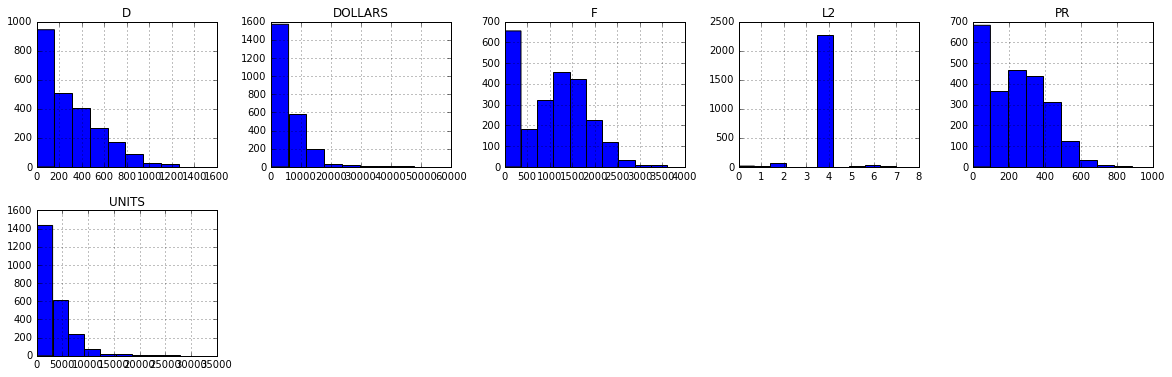

In [207]:
# looking at the histogram and statistics of the features to be able to omit features with not enough data #
saltsnck_preped_grp.hist(figsize=(20,50), layout=(15,5))
saltsnck_preped_grp.describe()

# Outlier Detection and Removal

**We assume that all features have Gaussian distribution and detect outliers based on the following rule:**

Detect a column with extreme outlier if $max (col)> mean(col)+10*\sigma $ 

In [132]:
def outlier_detector(data):
    out_col=[]
    data=data.copy()
    for col in data.describe().columns:
        maxx = data.describe()[col]['max']
        minn = data.describe()[col]['min']
        mean = data.describe()[col]['mean']
        std =  data.describe()[col]['std']

        if maxx>(mean+10*std):
            out_col.append(col)
            print "outliers for column", col, "are",np.unique(data[col].ix[data[col]>(mean+10*std)].values)
            data=data[data[col]<(mean+10*std)]
        elif minn<(mean-10*std):
            out_col.append(col)
            print "outliers for column", col, "are",np.unique(saltsnck_preped[col].ix[saltsnck_preped[col]>(mean-10*std)].values)
            data=data[data[col]>(mean-10*std)]
    print "columns containing outliers are: ",out_col
    return data

In [133]:
saltsnck_preped_grp=outlier_detector(saltsnck_preped_grp)

columns containing outliers are:  []


# Creating Model

In [208]:
feature_cols = saltsnck_preped_grp.columns-['DOLLARS','UNITS','L2']
target_col1 = 'L2'
target_col2 = 'DOLLARS'


target1 = saltsnck_preped_grp[target_col1]
target2 = saltsnck_preped_grp[target_col2]
features = saltsnck_preped_grp[feature_cols]

features.head()

C:\Users\phesami\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':


,D,F,PR
0,87,1422,272
1,249,1646,297
2,110,1818,378
3,198,1894,402
4,0,17,6


# classifying the product category

### Decision Tree

In [209]:
X_train, X_test, y_train, y_test = train_test_split(features, target1, test_size=0.2, random_state=4)
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
print "score on train set:", dtree.score(X_train, y_train)
print "score on test set:", dtree.score(X_test, y_test)
print('CV Variance score: %.2f' % np.mean(cross_validation.cross_val_score(dtree, features, target1, cv=10)))


score on train set: 0.991273100616
score on test set: 0.852459016393
CV Variance score: 0.87


In [210]:
pca = decomposition.PCA()
pca.fit(features)
features = pca.transform(features)
pca.explained_variance_ratio_

array([ 0.94842586,  0.04472492,  0.00684923])

# predicting the dollar amount

### Random Forest

In [211]:
X_train, X_test, y_train, y_test = train_test_split(features, target2, test_size=0.2, random_state=4)
tree = RandomForestRegressor()
tree.fit(X_train, y_train)
print "score on train set:", tree.score(X_train, y_train)
print "score on test set:", tree.score(X_test, y_test)
print('CV Variance score: %.2f' % np.mean(cross_validation.cross_val_score(tree, features, target2, cv=10)))

score on train set: 0.964867467163
score on test set: 0.873442189191
CV Variance score: 0.80


# Stacking

In [ ]:
## writing a class with fit/predict/scoring method, to fit the sub-classifiers onto the data and fit
# a meta classifier on top of the base classifier and evaluate the performance
class stacked_classifier():
    def __init__(self, base_classifiers=None, meta_classifier=None):
        self.base_classifiers = base_classifiers
        self.meta_classifier = meta_classifier


    def fit(self, X, y):
        for classifier in self.base_classifiers:
            classifier.fit(X, y)
        X_meta=self.predict_base(X)
        self.meta_classifier.fit(X_meta, y)

    def predict_base(self, X):
        self.predictions = np.zeros(len(X))
        for classifier in self.base_classifiers:
            self.predictions=np.column_stack([self.predictions, classifier.predict(X)])
        return self.predictions
        
    def scoring(self,X,y):
        clf_score=[]
        for classifier in self.base_classifiers:
            #print "The score of base classifier", type(classifier), "is: ", classifier.score(X, y)
            clf_score.append(classifier.score(X, y))
        #print "The score of the final stacked classifier is: ", self.meta_classifier.score(self.predict_base(X),y)
        clf_score.append(self.meta_classifier.score(self.predict_base(X),y))
        return clf_score

# Creating sub and meta classifiers

In [ ]:
DTC = DecisionTreeClassifier(random_state=0)
LR = linear_model.LogisticRegression()
RC =  linear_model.RidgeClassifier(random_state=1)
ETC = ExtraTreeClassifier(random_state=32)
KNC = KNeighborsClassifier ()
BC = BaggingClassifier()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target1, test_size=0.2, random_state=4)

# Importing the results of all possible combinations of base+meta classifier into a DataFrame

In [ ]:
def stack_scoring(clf_dict, score_df, n):
    l=0
    for clf in combinations(clf_dict,n):
        stacked_clf=stacked_classifier(base_classifiers=clf[0:n-1], meta_classifier=clf[n-1])
        stacked_clf.fit(X_train,y_train)
        clf_scores=[clf_dict.get(clf[i]) for i in range(n)]+stacked_clf.scoring(X_test,y_test)
        score_df.loc[l]= clf_scores
        l+=1
    return score_df

In [ ]:
clf_dict={DTC: 'Decision Tree',LR:'Logistic Regression',RC: 'Ridge', ETC: 'Extra Tree', KNC:'KNeighbor', BC:'Bagging'}
score_df = pd.DataFrame(columns=['Base1','Base2','Base3', 'Meta','Base1 Score','Base2 Score','Base3 Score', 'Meta Score'])

stack_2_base_score = stack_scoring(clf_dict,score_df, 4)
print "Best stacked classifier with 2 sub-classifier is: \n", stack_2_base_score.loc[stack_2_base_score['Meta Score'].idxmax()]
stack_2_base_score